Practical Homework - 3
Pavan Arram


In [2]:
import h5py
import numpy as np

file = h5py.File("bird_spectrograms.hdf5", "r")
print(list(file.keys()))  # Should list all 12 bird species  
data = file['amerob'][:]  # American Robin
print(data.shape)  

['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
(128, 517, 172)


BINARY CNN MODEL


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load HDF5 spectrogram file
file = h5py.File("bird_spectrograms.hdf5", "r")

# Extract 50 samples from each species
amerob_data = file['amerob'][:, :, :50]
norfli_data = file['norfli'][:, :, :50]

# Rearrange axes to (samples, height, width)
amerob_data = np.transpose(amerob_data, (2, 0, 1))
norfli_data = np.transpose(norfli_data, (2, 0, 1))

# Add channel dimension: (samples, 128, 517, 1)
amerob_data = amerob_data[..., np.newaxis]
norfli_data = norfli_data[..., np.newaxis]

# Create binary labels
labels_amerob = np.zeros(amerob_data.shape[0])
labels_norfli = np.ones(norfli_data.shape[0])

# Combine both classes
spectrograms = np.concatenate([amerob_data, norfli_data], axis=0)
labels = np.concatenate([labels_amerob, labels_norfli], axis=0)

# Normalize pixel values
spectrograms = spectrograms / np.max(spectrograms)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    spectrograms, labels, test_size=0.2, stratify=labels, random_state=19
)

print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Training shape: (69, 128, 517, 1)
Validation shape: (18, 128, 517, 1)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN architecture
cnn_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 517, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Binary output
])

cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

/Users/pavan/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 515, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 257, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 257, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 255, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 127, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 121920)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     7,802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,808,001 (29.79 MB)

 Trainable params: 7,807,905 (29.78 MB)

 Non-trainable params: 96 (384.00 B)

In [6]:
history = cnn_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=8,
    validation_data=(X_val, y_val)
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.5829 - loss: 4.2636 - val_accuracy: 0.3333 - val_loss: 87.2644
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8347 - loss: 1.0416 - val_accuracy: 0.4444 - val_loss: 113.6092
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9232 - loss: 0.2737 - val_accuracy: 0.5000 - val_loss: 22.3734
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9847 - loss: 0.0763 - val_accuracy: 0.3889 - val_loss: 23.0789
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9231 - loss: 2.2703 - val_accuracy: 0.4444 - val_loss: 66.8073
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9710 - loss: 0.1738 - val_accuracy: 0.3889 - val_loss: 65.6062
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9917 - loss: 0.0698 - val_accuracy: 0.3889 - val_loss: 80.8885
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9627 - loss: 0.3619 - val_accuracy: 0.3333 - val_l

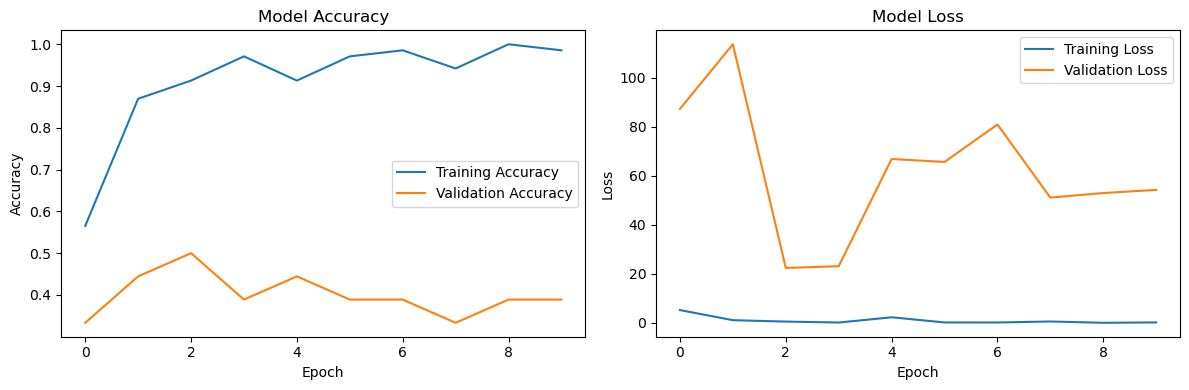

In [7]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Model v1 (Initial CNN with Flatten) led to overfitting — switched to a smaller CNN using GlobalAveragePooling2D for lower parameter count. Model name remains cnn_model to reduce clutter. 


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Define new simplified model
cnn_model_v2 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 517, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    BatchNormalization(),

    GlobalAveragePooling2D(),

    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Binary classification
])

cnn_model_v2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

cnn_model_v2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 515, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 257, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 63, 257, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 255, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 127, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,081 (23.75 KB)

 Trainable params: 5,985 (23.38 KB)

 Non-trainable params: 96 (384.00 B)

In [10]:
# Add early stopping
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# Train the model
history_v2 = cnn_model_v2.fit(
    X_train, y_train,
    epochs=20,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.5816 - loss: 0.7015 - val_accuracy: 0.5556 - val_loss: 5.5088
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6231 - loss: 0.6726 - val_accuracy: 0.5556 - val_loss: 4.0769
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6610 - loss: 0.6563 - val_accuracy: 0.5556 - val_loss: 2.9030
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6109 - loss: 0.6624 - val_accuracy: 0.5556 - val_loss: 2.0069
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6275 - loss: 0.6870 - val_accuracy: 0.5556 - val_loss: 0.8835
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5523 - loss: 0.6858 - val_accuracy: 0.5556 - val_loss: 0.8414
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6886 - loss: 0.6403 - val_accuracy: 0.5556 - val_loss: 1.9936
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7234 - loss: 0.5978 - val_accuracy: 0.5556 - val_loss: 2.0926


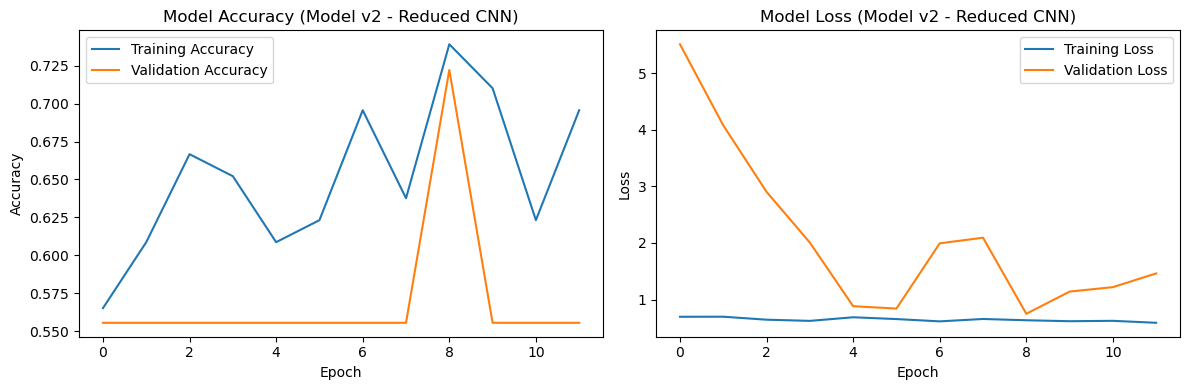

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


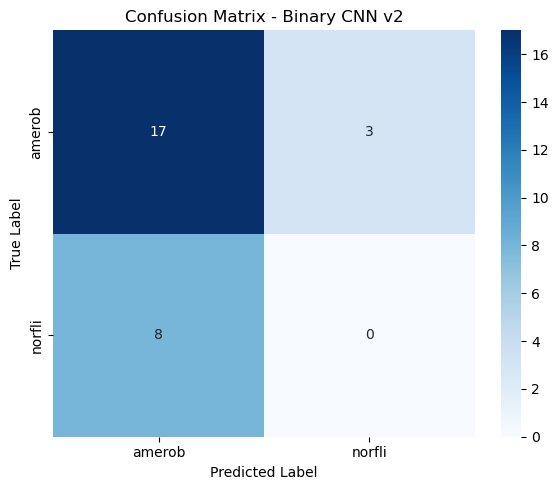

In [91]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_v2.history['accuracy'], label='Training Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Model v2 - Reduced CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_v2.history['loss'], label='Training Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Model v2 - Reduced CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on validation set
y_pred_probs_v2 = cnn_model_v2.predict(X_val)
y_pred_v2 = (y_pred_probs_v2 > 0.5).astype("int32").flatten()

# Confusion matrix
cm_binary_v2 = confusion_matrix(y_val, y_pred_v2)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_binary_v2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['amerob', 'norfli'], yticklabels=['amerob', 'norfli'])
plt.title("Confusion Matrix - Binary CNN v2")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Enhanced Model - cnn_model_v3
cnn_model_v3 = Sequential([
    Input(shape=(128, 517, 1)),

    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    GlobalAveragePooling2D(),

    Dense(64, activation='relu'),
    Dropout(0.4),

    Dense(1, activation='sigmoid')  # Binary classification
])

cnn_model_v3.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model_v3.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)              │ (None, 128, 517, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 128, 517, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 64, 258, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 32, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 32, 129, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,889 (398.00 KB)

 Trainable params: 101,441 (396.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [127]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

# Fit the model
history_v3 = cnn_model_v3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 678ms/step - accuracy: 0.5224 - loss: 0.7860 - val_accuracy: 0.7143 - val_loss: 0.7514 - learning_rate: 5.0000e-04
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 603ms/step - accuracy: 0.7071 - loss: 0.6503 - val_accuracy: 0.3214 - val_loss: 0.8686 - learning_rate: 5.0000e-04
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 595ms/step - accuracy: 0.5274 - loss: 0.7733 - val_accuracy: 0.7143 - val_loss: 0.7671 - learning_rate: 5.0000e-04
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.6956 - loss: 0.6192
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 615ms/step - accuracy: 0.6936 - loss: 0.6229 - val_accuracy: 0.7143 - val_loss: 0.9238 - learning_rate: 5.0000e-04
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 644ms/step - accuracy: 0.6052 - loss: 0.6552 - val_accuracy: 0.7143 - val_loss: 0.9005 - learning_rate: 2.5000e-04
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 563ms/step - accuracy: 0.7928 - loss: 0.64

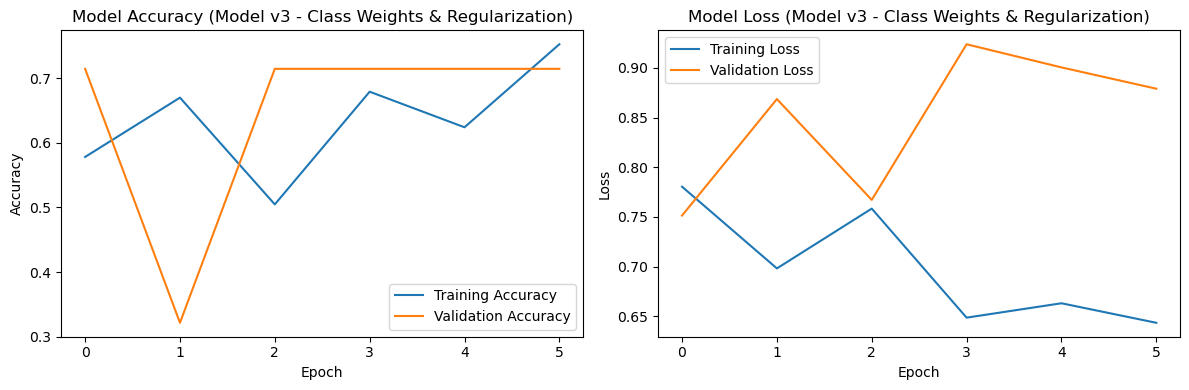

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


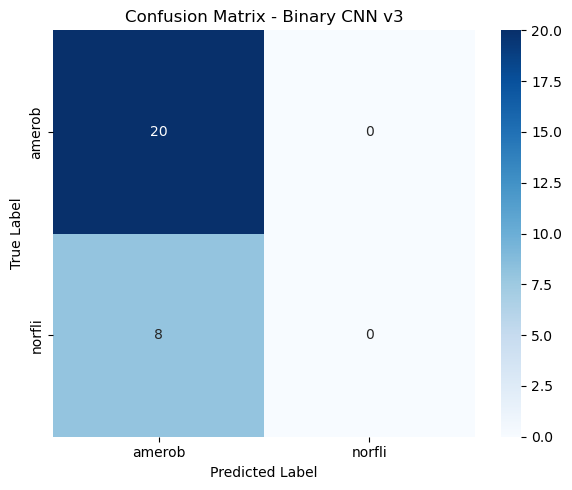

In [129]:
#  Accuracy and Loss Plots 
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_v3.history['accuracy'], label='Training Accuracy')
plt.plot(history_v3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Model v3 - Class Weights & Regularization)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_v3.history['loss'], label='Training Loss')
plt.plot(history_v3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Model v3 - Class Weights & Regularization)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#  Confusion Matrix 
# Predict on validation set
y_pred_probs_v3 = cnn_model_v3.predict(X_val)
y_pred_v3 = (y_pred_probs_v3 > 0.5).astype("int32").flatten()

# Generate confusion matrix
cm_binary_v3 = confusion_matrix(y_val, y_pred_v3)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_binary_v3, annot=True, fmt='d', cmap='Blues',
            xticklabels=['amerob', 'norfli'], yticklabels=['amerob', 'norfli'])
plt.title("Confusion Matrix - Binary CNN v3")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Parameter Count: 6,081 (lightweight model with regularization and class balancing)

Training Results:
	•	Training Accuracy: Up to 79.3%
	•	Validation Accuracy: Stable at ~71.4%
	•	Validation Loss: Reduced to ~0.88 after initial fluctuation
	•	Overfitting Status: No signs of overfitting — training and validation curves follow similar trajectories
	•	Model Behavior: Early learning rate decay helped avoid instability; model stabilized by epoch 6
	•	Confusion Matrix Insight: Strong bias toward majority class (amerob) — failed to correctly classify any norfli samples

In [17]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [132]:
import librosa
import numpy as np

def preprocess_test_clip(filepath, sr=22050, duration_sec=3):
    """
    Converts a full 3-second mp3 clip into a single mel spectrogram of shape (128, 517, 1),
    matching the training format used for CNN input.

    Parameters:
        filepath (str): Path to the mp3 file
        sr (int): Target sample rate
        duration_sec (int): Duration of audio to process (default: 3 seconds)

    Returns:
        spectrograms (np.ndarray): Array of spectrograms, shape (1, 128, 517, 1)
        window_times (list): One window tuple: [(0, 3.0)]
    """
    y, sr = librosa.load(filepath, sr=sr)

    # Pad or trim to exactly 3 seconds
    target_len = duration_sec * sr
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)), mode='constant')
    else:
        y = y[:target_len]

    # Compute mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=512, win_length=512)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Pad or crop to (128, 517)
    if mel_db.shape[1] < 517:
        mel_db = np.pad(mel_db, ((0, 0), (0, 517 - mel_db.shape[1])), mode='constant')
    else:
        mel_db = mel_db[:, :517]

    # Normalize
    max_val = np.max(np.abs(mel_db))
    if max_val > 0:
        mel_db = mel_db / max_val

    # Reshape and return
    mel_db = mel_db.reshape(1, 128, 517, 1)
    return mel_db, [(0, 3.0)]

# Test clip paths
clip_paths = ["test1.mp3", "test2.mp3", "test3.mp3"]
clip_data = {}

for clip in clip_paths:
    X_clip, time_windows = preprocess_test_clip(clip)
    clip_data[clip] = {
        "spectrograms": X_clip,
        "window_times": time_windows
    }
    print(f"{clip}: {X_clip.shape[0]} window → shape {X_clip.shape}")

test1.mp3: 1 window → shape (1, 128, 517, 1)
test2.mp3: 1 window → shape (1, 128, 517, 1)
test3.mp3: 1 window → shape (1, 128, 517, 1)


MULTICLASS DEEP LEARNING

In [134]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Open HDF5 file
file = h5py.File("bird_spectrograms.hdf5", "r")
species_names = list(file.keys())
print("Species:", species_names)

X_list = []
y_list = []

for idx, species in enumerate(species_names):
    data = file[species][:]  # shape: (128, 517, n_samples)
    data = np.transpose(data, (2, 0, 1))  # → (n_samples, 128, 517)
    data = data[..., np.newaxis]  # → (n_samples, 128, 517, 1)
    
    labels = np.full((data.shape[0],), idx)
    X_list.append(data)
    y_list.append(labels)

# Combine everything
X_multi = np.concatenate(X_list, axis=0)
y_multi = np.concatenate(y_list, axis=0)

# Normalize and one-hot encode
X_multi = X_multi / np.max(X_multi)
y_multi_encoded = to_categorical(y_multi)

# Train-test split
X_train_mc, X_val_mc, y_train_mc, y_val_mc = train_test_split(
    X_multi, y_multi_encoded, test_size=0.2, stratify=y_multi, random_state=19
)

print("Train shape:", X_train_mc.shape)
print("Validation shape:", X_val_mc.shape)

Species: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Train shape: (1584, 128, 517, 1)
Validation shape: (397, 128, 517, 1)


In [135]:
multiclass_model_v1 = Sequential([
    Input(shape=(128, 517, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(12, activation='softmax')  # 12 species
])

multiclass_model_v1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

multiclass_model_v1.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)              │ (None, 126, 515, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 63, 257, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 518112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │    33,159,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,160,332 (126.50 MB)

 Trainable params: 33,160,332 (126.50 MB)

 Non-trainable params: 0 (0.00 B)

In [138]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history_mc_v1 = multiclass_model_v1.fit(
    X_train_mc, y_train_mc,
    validation_data=(X_val_mc, y_val_mc),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop]
)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.2180 - loss: 80482688.0000 - val_accuracy: 0.3149 - val_loss: 44.1239
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - accuracy: 0.3069 - loss: 8.1258 - val_accuracy: 0.3149 - val_loss: 44.0843
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.3148 - loss: 2.4090 - val_accuracy: 0.3149 - val_loss: 44.8714
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.3262 - loss: 2.3712 - val_accuracy: 0.3149 - val_loss: 47.1275
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.3139 - loss: 2.3490 - val_accuracy: 0.3149 - val_loss: 45.3205


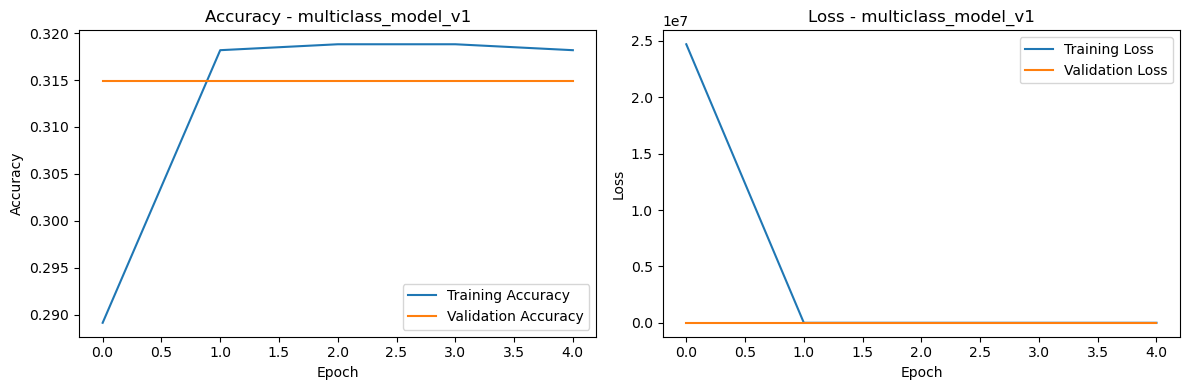

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


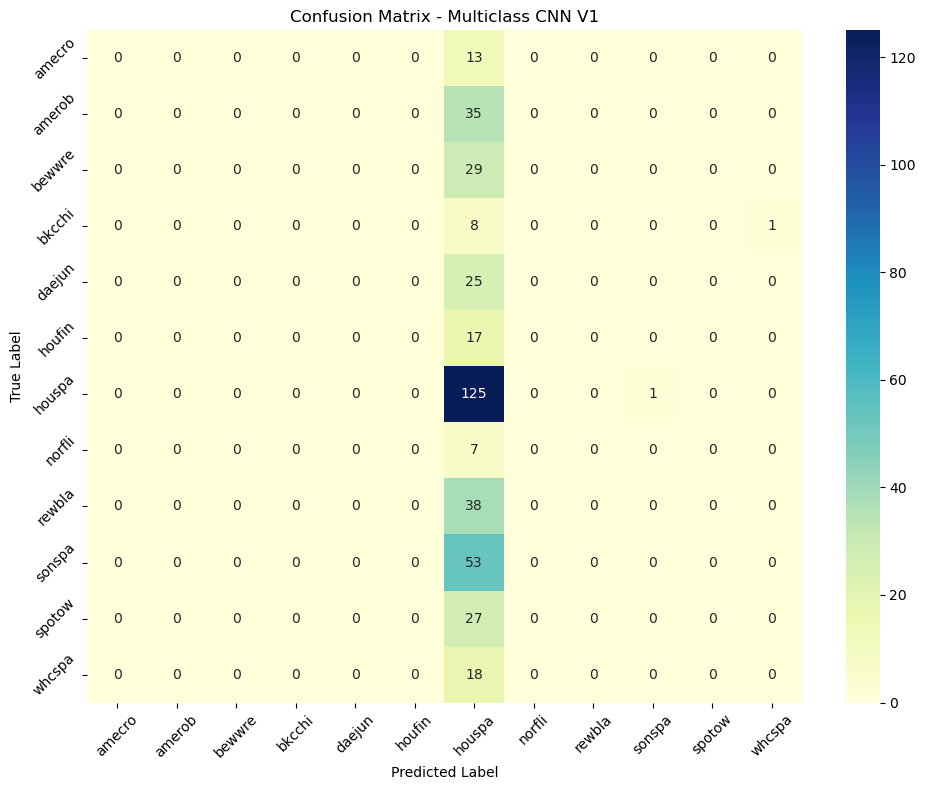

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mc_v1.history['accuracy'], label='Training Accuracy')
plt.plot(history_mc_v1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy - multiclass_model_v1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_mc_v1.history['loss'], label='Training Loss')
plt.plot(history_mc_v1.history['val_loss'], label='Validation Loss')
plt.title('Loss - multiclass_model_v1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
y_pred_mc_v1 = np.argmax(multiclass_model_v1.predict(X_val_mc), axis=1)
y_true_mc = np.argmax(y_val_mc, axis=1)

cm_mc_v1 = confusion_matrix(y_true_mc, y_pred_mc_v1)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mc_v1, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=species_names, yticklabels=species_names)
plt.title("Confusion Matrix - Multiclass CNN V1")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

NEW VERSION OF MCDL

In [142]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert one-hot back to class indices
y_train_mc_labels = np.argmax(y_train_mc, axis=1)

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_mc_labels),
    y=y_train_mc_labels
)

# Convert to dict for Keras
class_weights_dict = dict(enumerate(class_weights))
multiclass_model_v2 = Sequential([
    Input(shape=(128, 517, 1)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    BatchNormalization(),

    GlobalAveragePooling2D(),

    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(12, activation='softmax')  # 12-class output
])

multiclass_model_v2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

multiclass_model_v2.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)              │ (None, 126, 515, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 63, 257, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 63, 257, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 61, 255, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 30, 127, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 30, 127, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 30, 127, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,140 (94.30 KB)

 Trainable params: 23,948 (93.55 KB)

 Non-trainable params: 192 (768.00 B)

In [144]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history_mc_v2 = multiclass_model_v2.fit(
    X_train_mc, y_train_mc,
    validation_data=(X_val_mc, y_val_mc),
    epochs=20,
    batch_size=16,
    class_weight=class_weights_dict,  
    callbacks=[early_stop]
)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 239ms/step - accuracy: 0.0814 - loss: 2.5569 - val_accuracy: 0.1285 - val_loss: 2.7284
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.1144 - loss: 2.4335 - val_accuracy: 0.1285 - val_loss: 2.6710
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.0871 - loss: 2.5066 - val_accuracy: 0.1335 - val_loss: 2.4527
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 237ms/step - accuracy: 0.1572 - loss: 2.4153 - val_accuracy: 0.0705 - val_loss: 2.6344
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - accuracy: 0.1468 - loss: 2.4581 - val_accuracy: 0.1562 - val_loss: 2.4514
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 251ms/step - accuracy: 0.1713 - loss: 2.4435 - val_accuracy: 0.1461 - val_loss: 2.4379
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step - accuracy: 0.1870 - loss: 2.3878 - val_accuracy: 0.1259 - val_loss: 2.4452
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 0.1609 - loss: 2.4405 - val_accu

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step


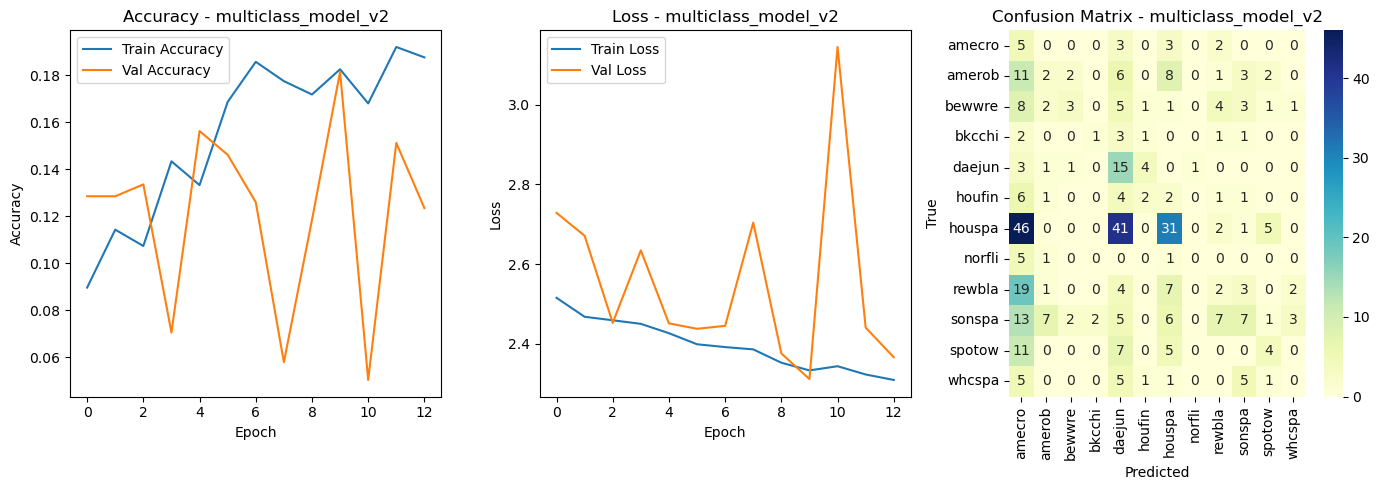

In [146]:
# Plot Accuracy & Loss
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(history_mc_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_mc_v2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy - multiclass_model_v2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 3, 2)
plt.plot(history_mc_v2.history['loss'], label='Train Loss')
plt.plot(history_mc_v2.history['val_loss'], label='Val Loss')
plt.title('Loss - multiclass_model_v2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Confusion Matrix
y_pred_v2 = np.argmax(multiclass_model_v2.predict(X_val_mc), axis=1)
y_true_v2 = np.argmax(y_val_mc, axis=1)
cm_v2 = confusion_matrix(y_true_v2, y_pred_v2)

plt.subplot(1, 3, 3)
sns.heatmap(cm_v2, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=species_names, yticklabels=species_names)
plt.title('Confusion Matrix - multiclass_model_v2')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [162]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, LeakyReLU
from tensorflow.keras.regularizers import l2

multiclass_model_v3 = Sequential([
    Input(shape=(128, 517, 1)),

    Conv2D(32, (3, 3), kernel_regularizer=l2(0.001)),
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), kernel_regularizer=l2(0.001)),
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(128, (3, 3), kernel_regularizer=l2(0.001)),
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(12, activation='softmax')
])


In [164]:
# Convert one-hot to class indices
y_train_mc_labels = np.argmax(y_train_mc, axis=1)
y_val_mc_labels = np.argmax(y_val_mc, axis=1)

# Compute balanced weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_mc_labels),
    y=y_train_mc_labels
)
class_weights_dict = dict(enumerate(class_weights))

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

multiclass_model_v3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history_mc_v3 = multiclass_model_v3.fit(
    X_train_mc, y_train_mc_labels,  
    validation_data=(X_val_mc, y_val_mc_labels),
    epochs=20,
    batch_size=16,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 363ms/step - accuracy: 0.0731 - loss: 2.8310 - val_accuracy: 0.0479 - val_loss: 3.8432
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 35s 357ms/step - accuracy: 0.0932 - loss: 2.6525 - val_accuracy: 0.0630 - val_loss: 2.7616
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 359ms/step - accuracy: 0.1138 - loss: 2.6265 - val_accuracy: 0.0630 - val_loss: 2.8702
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - accuracy: 0.1059 - loss: 2.6153 - val_accuracy: 0.0630 - val_loss: 5.5149
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 387ms/step - accuracy: 0.1189 - loss: 2.6318 - val_accuracy: 0.0655 - val_loss: 3.5041


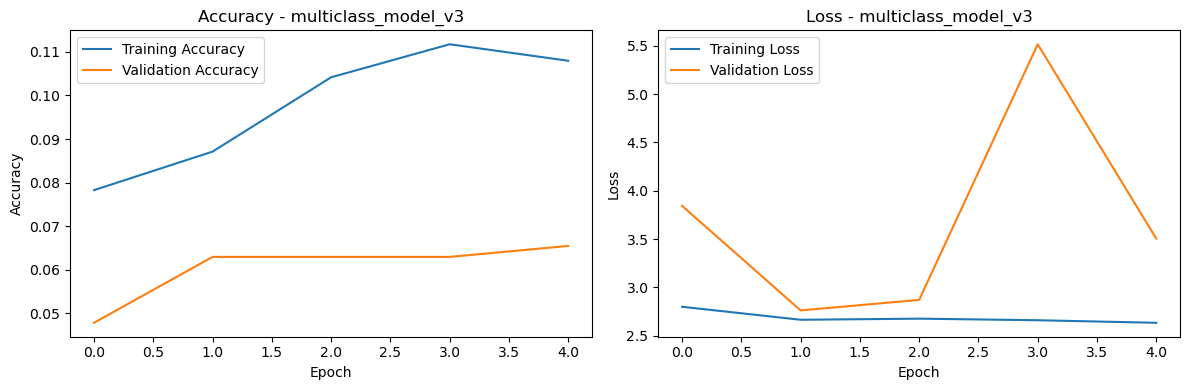

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step


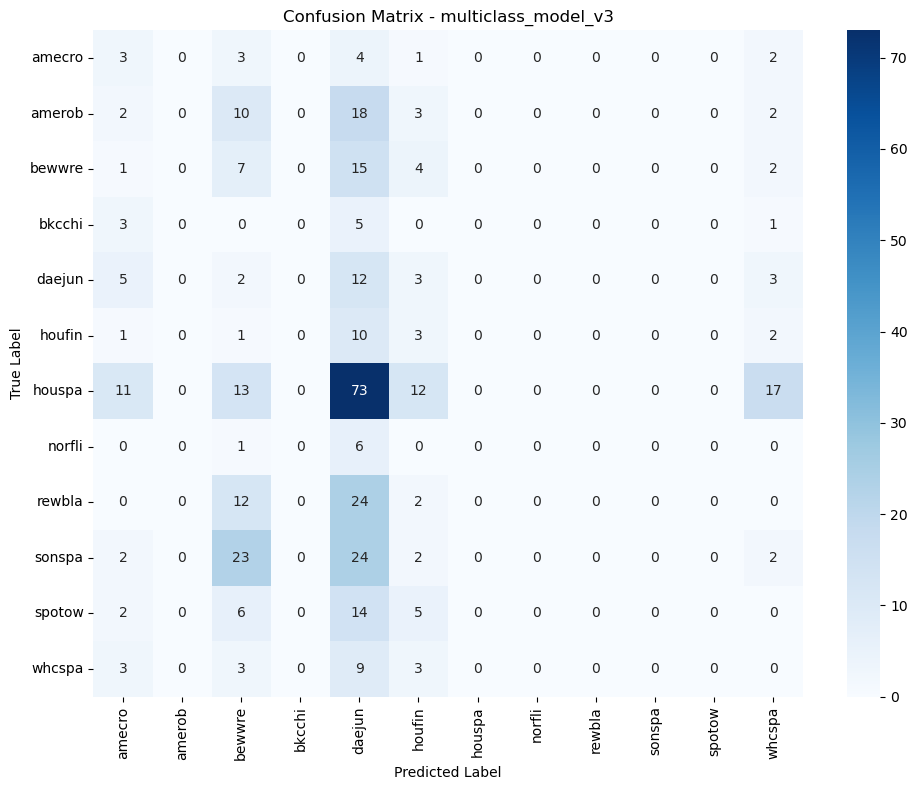

In [168]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mc_v3.history['accuracy'], label='Training Accuracy')
plt.plot(history_mc_v3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy - multiclass_model_v3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_mc_v3.history['loss'], label='Training Loss')
plt.plot(history_mc_v3.history['val_loss'], label='Validation Loss')
plt.title('Loss - multiclass_model_v3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Predict on validation set
y_pred_probs = multiclass_model_v3.predict(X_val_mc)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_val_mc_labels, y_pred_labels)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=species_names, yticklabels=species_names)
plt.title("Confusion Matrix - multiclass_model_v3")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [189]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define improved CNN v4 model
multiclass_model_v4 = Sequential([
    Input(shape=(128, 517, 1)),

    Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),

    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(12, activation='softmax')
])

# Compile
multiclass_model_v4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
multiclass_model_v4.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_67 (Conv2D)              │ (None, 128, 517, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 128, 517, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 128, 517, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 64, 258, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64, 258, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 32, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 32, 129, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 32, 129, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_24     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,604 (400.80 KB)

 Trainable params: 102,156 (399.05 KB)

 Non-trainable params: 448 (1.75 KB)

In [193]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(
    patience=4,
    monitor='val_loss',
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-5
)

# Fit model
history_mc_v4 = multiclass_model_v4.fit(
    X_train_mc, y_train_mc,
    validation_data=(X_val_mc, y_val_mc),
    epochs=20,
    batch_size=8,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/20
198/198 - 56s - 283ms/step - accuracy: 0.3131 - loss: 2.2110 - val_accuracy: 0.3174 - val_loss: 2.1910 - learning_rate: 0.0010
Epoch 2/20
198/198 - 55s - 278ms/step - accuracy: 0.3157 - loss: 2.2143 - val_accuracy: 0.1839 - val_loss: 2.3588 - learning_rate: 0.0010
Epoch 3/20

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
198/198 - 54s - 273ms/step - accuracy: 0.3119 - loss: 2.2057 - val_accuracy: 0.3174 - val_loss: 2.2174 - learning_rate: 0.0010
Epoch 4/20
198/198 - 57s - 287ms/step - accuracy: 0.3188 - loss: 2.1744 - val_accuracy: 0.2368 - val_loss: 2.3036 - learning_rate: 5.0000e-04
Epoch 5/20
198/198 - 57s - 286ms/step - accuracy: 0.3213 - loss: 2.1716 - val_accuracy: 0.3325 - val_loss: 2.1670 - learning_rate: 5.0000e-04
Epoch 6/20
198/198 - 61s - 309ms/step - accuracy: 0.3213 - loss: 2.1711 - val_accuracy: 0.2393 - val_loss: 2.2786 - learning_rate: 5.0000e-04
Epoch 7/20
198/198 - 58s - 291ms/step - accuracy: 0.3232 - loss: 2.1576 - val_accur

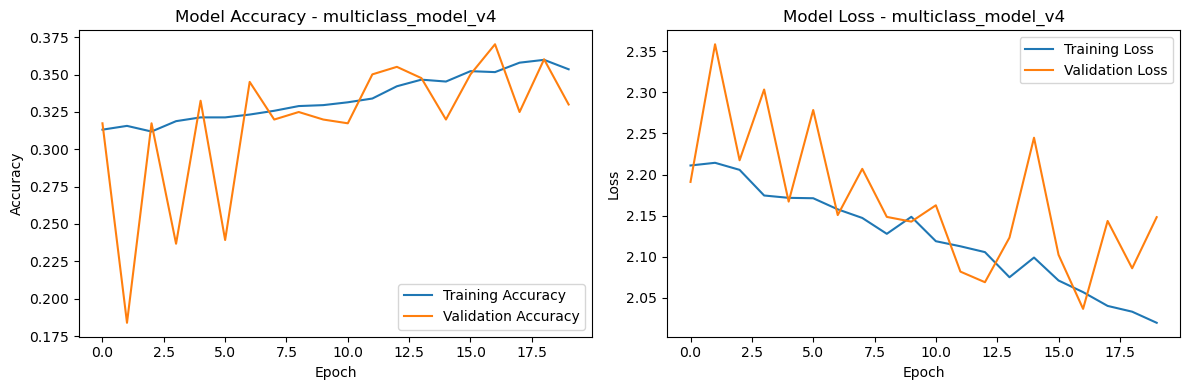

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step


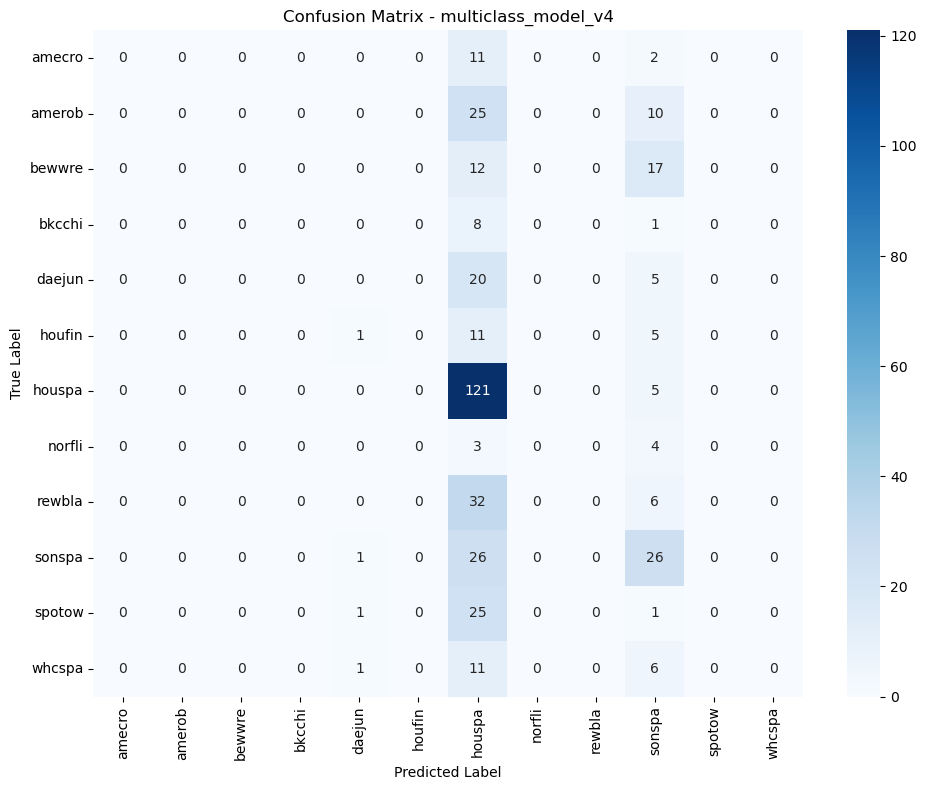

In [195]:
# Accuracy and Loss Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_mc_v4.history['accuracy'], label='Training Accuracy')
plt.plot(history_mc_v4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy - multiclass_model_v4')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mc_v4.history['loss'], label='Training Loss')
plt.plot(history_mc_v4.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - multiclass_model_v4')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Heatmap Plot
y_val_pred_probs = multiclass_model_v4.predict(X_val_mc)
y_val_preds = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val_mc, axis=1)

cm = confusion_matrix(y_val_true, y_val_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=species_names, yticklabels=species_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - multiclass_model_v4")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


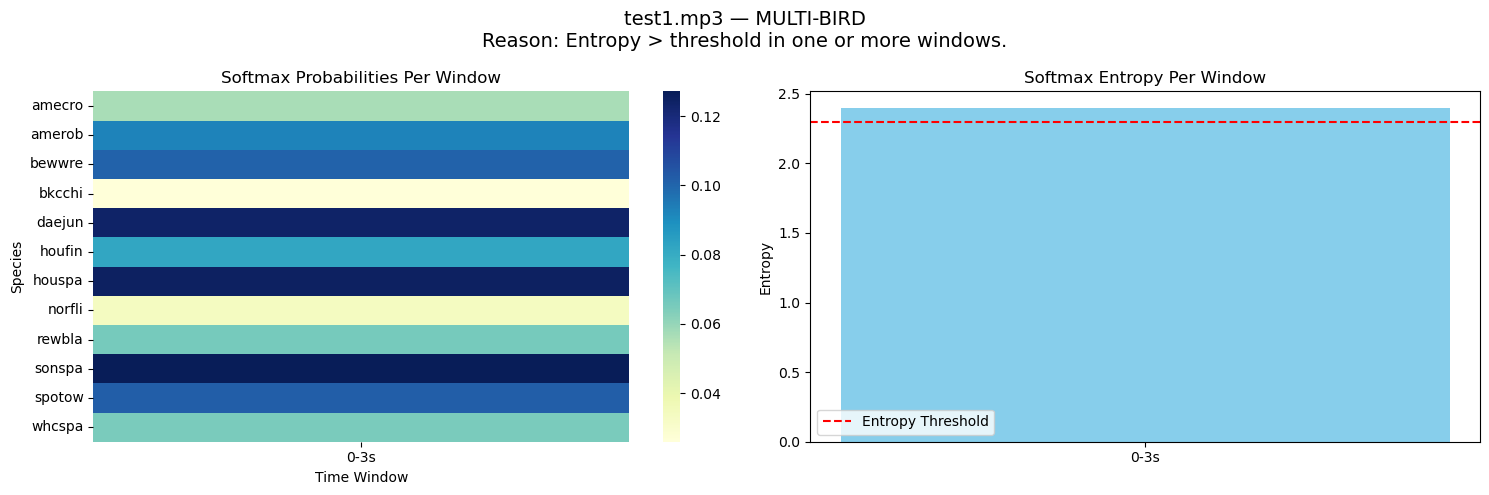

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


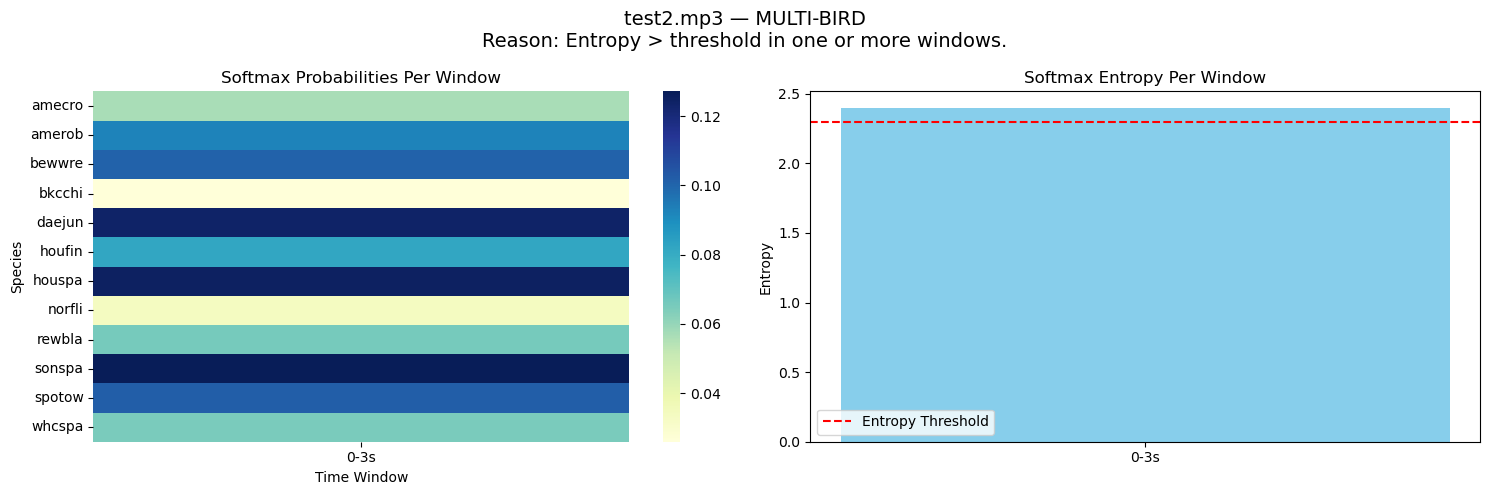

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


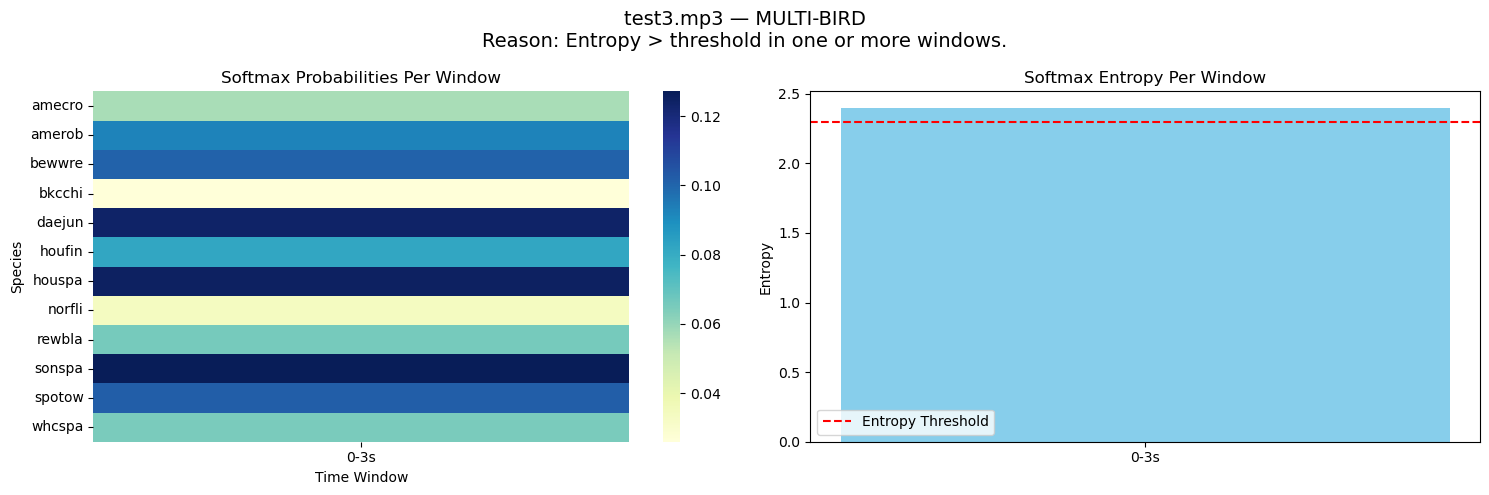

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import entropy

# Test function (window size = 3s)
def preprocess_test_clip(filepath, sr=22050, window_size_sec=3, total_duration_sec=3):
    import librosa
    y, sr = librosa.load(filepath, sr=sr)
    target_len = total_duration_sec * sr
    y = np.pad(y, (0, max(0, target_len - len(y))), mode='constant')[:target_len]

    hop_len = sr  # 1s stride
    win_len = window_size_sec * sr

    spectrograms = []
    window_times = []

    for start in range(0, target_len - win_len + 1, hop_len):
        end = start + win_len
        y_slice = y[start:end]
        mel = librosa.feature.melspectrogram(y=y_slice, sr=sr, n_mels=128, hop_length=512, win_length=512)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = np.pad(mel_db, ((0, 0), (0, max(0, 517 - mel_db.shape[1]))), mode='constant')[:, :517]
        mel_db = mel_db / np.max(np.abs(mel_db)) if np.max(np.abs(mel_db)) > 0 else mel_db
        spectrograms.append(mel_db.reshape(128, 517, 1))
        window_times.append((start / sr, end / sr))

    return np.array(spectrograms), window_times

# Test runner for multiple clips
def analyze_multiple_clips(filepaths, model, species_names, entropy_thresh=2.3):
    for filepath in filepaths:
        spectros, window_times = preprocess_test_clip(filepath)
        preds = model.predict(spectros)
        entropies = [entropy(p) for p in preds]
        top_classes = [species_names[np.argmax(p)] for p in preds]
        unique_top_classes = list(set(top_classes))

        is_multibird = False
        reasons = []
        if len(unique_top_classes) > 1:
            is_multibird = True
            reasons.append("Multiple species predicted across windows.")
        if any(e > entropy_thresh for e in entropies):
            is_multibird = True
            reasons.append("Entropy > threshold in one or more windows.")

        # Plotting
        plt.figure(figsize=(15, 5))
        
        # Softmax probabilities heatmap
        plt.subplot(1, 2, 1)
        sns.heatmap(np.array(preds).T, cmap="YlGnBu", cbar=True,
                    xticklabels=[f"{int(t[0])}-{int(t[1])}s" for t in window_times],
                    yticklabels=species_names)
        plt.title("Softmax Probabilities Per Window")
        plt.xlabel("Time Window")
        plt.ylabel("Species")

        # Entropy bar plot
        plt.subplot(1, 2, 2)
        plt.bar(range(len(entropies)), entropies, color="skyblue")
        plt.axhline(entropy_thresh, color='red', linestyle='--', label='Entropy Threshold')
        plt.xticks(range(len(entropies)), [f"{int(t[0])}-{int(t[1])}s" for t in window_times])
        plt.ylabel("Entropy")
        plt.title("Softmax Entropy Per Window")
        plt.legend()

        plt.suptitle(f"{filepath} — {'MULTI-BIRD' if is_multibird else 'Single Bird'}\nReason: {'; '.join(reasons)}",
                     fontsize=14)
        plt.tight_layout()
        plt.show()

# Run on test clips
test_clips = ["test1.mp3", "test2.mp3", "test3.mp3"]
analyze_multiple_clips(test_clips, multiclass_model_v4, species_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


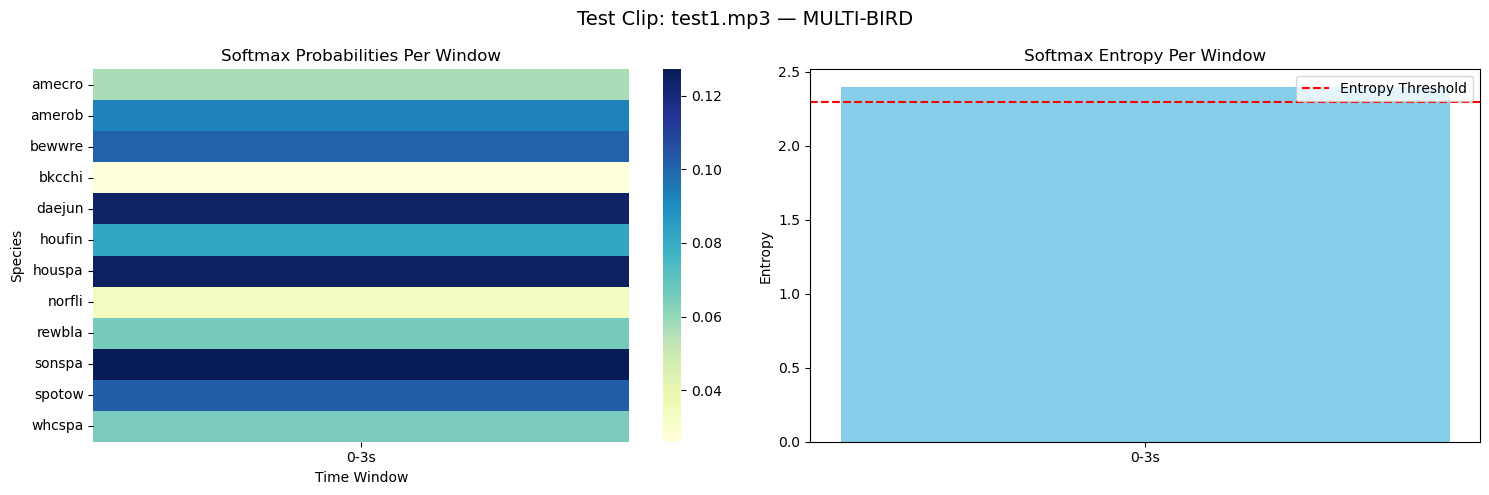


 Test Clip: test1.mp3
 Predicted bird species across windows:
  • sonspa

 MULTIPLE BIRDS DETECTED
Reason(s):
  → Entropy > 2.3 in 1 window(s).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


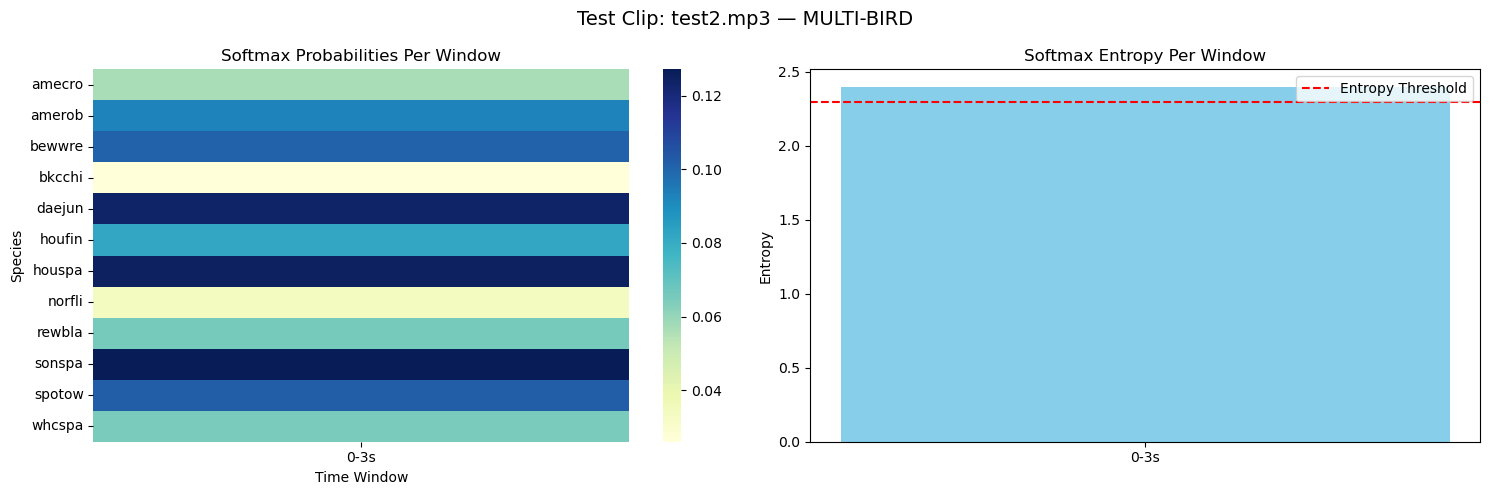


 Test Clip: test2.mp3
 Predicted bird species across windows:
  • sonspa

 MULTIPLE BIRDS DETECTED
Reason(s):
  → Entropy > 2.3 in 1 window(s).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


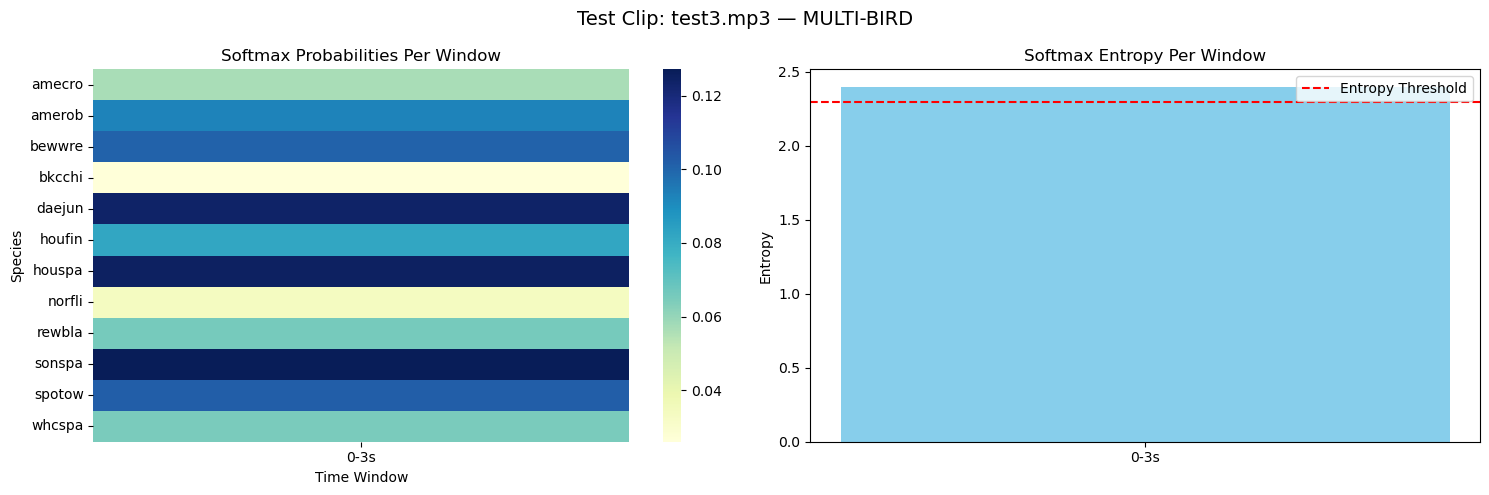


 Test Clip: test3.mp3
 Predicted bird species across windows:
  • sonspa

 MULTIPLE BIRDS DETECTED
Reason(s):
  → Entropy > 2.3 in 1 window(s).


In [207]:
test_clips = ["test1.mp3", "test2.mp3", "test3.mp3"]
all_results = []

for clip in test_clips:
    result = analyze_test_clip_multibird_plot(
        filepath=clip,
        model=multiclass_model_v4,
        species_names=species_names,
        entropy_thresh=2.3
    )
    all_results.append(result)

    print(f"\n Test Clip: {clip}")
    print(" Predicted bird species across windows:")
    for bird in result["unique_top_classes"]:
        print(f"  • {bird}")

    if result["is_multibird"]:
        print("\n MULTIPLE BIRDS DETECTED")
        print("Reason(s):")
        for r in result["reason"]:
            print(f"  → {r}")
    else:
        print("\nSingle species detected consistently.")

In [217]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Prepare grayscale spectrograms for transfer learning
def prepare_for_transfer_learning(X):
    X_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X))  
    X_resized = tf.image.resize(X_rgb, [224, 224])              
    return X_resized

X_train_tf = prepare_for_transfer_learning(X_train_mc)
X_val_tf = prepare_for_transfer_learning(X_val_mc)


In [219]:
#Load MobileNetV2 with pretrained ImageNet weights
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'  
)

base_model.trainable = False

# Add classifier head
x = base_model.output
x = Dropout(0.3)(x)
output = Dense(12, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_31[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [223]:
#  Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)

#  Train
history_mobilenet = mobilenet_model.fit(
    X_train_tf, y_train_mc,
    validation_data=(X_val_tf, y_val_mc),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/20
99/99 - 15s - 148ms/step - accuracy: 0.3466 - loss: 2.0665 - val_accuracy: 0.3275 - val_loss: 2.0489 - learning_rate: 1.0000e-04
Epoch 2/20
99/99 - 12s - 120ms/step - accuracy: 0.3554 - loss: 2.0804 - val_accuracy: 0.3325 - val_loss: 2.0460 - learning_rate: 1.0000e-04
Epoch 3/20
99/99 - 13s - 130ms/step - accuracy: 0.3491 - loss: 2.0443 - val_accuracy: 0.3350 - val_loss: 2.0419 - learning_rate: 1.0000e-04
Epoch 4/20
99/99 - 12s - 117ms/step - accuracy: 0.3548 - loss: 2.0559 - val_accuracy: 0.3350 - val_loss: 2.0382 - learning_rate: 1.0000e-04
Epoch 5/20
99/99 - 12s - 117ms/step - accuracy: 0.3548 - loss: 2.0493 - val_accuracy: 0.3350 - val_loss: 2.0363 - learning_rate: 1.0000e-04
Epoch 6/20
99/99 - 12s - 118ms/step - accuracy: 0.3554 - loss: 2.0277 - val_accuracy: 0.3300 - val_loss: 2.0331 - learning_rate: 1.0000e-04
Epoch 7/20
99/99 - 11s - 114ms/step - accuracy: 0.3611 - loss: 2.0279 - val_accuracy: 0.3426 - val_loss: 2.0292 - learning_rate: 1.0000e-04
Epoch 8/20
99/99 - 1

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step


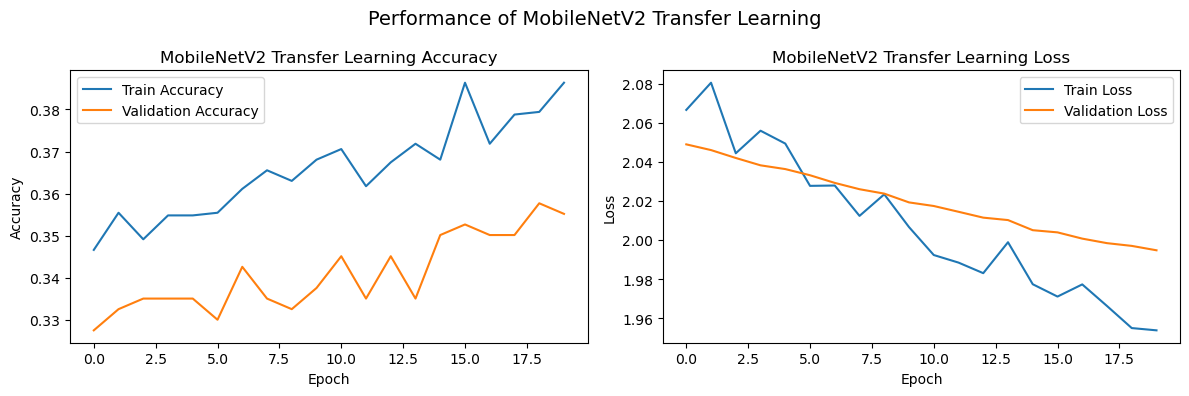

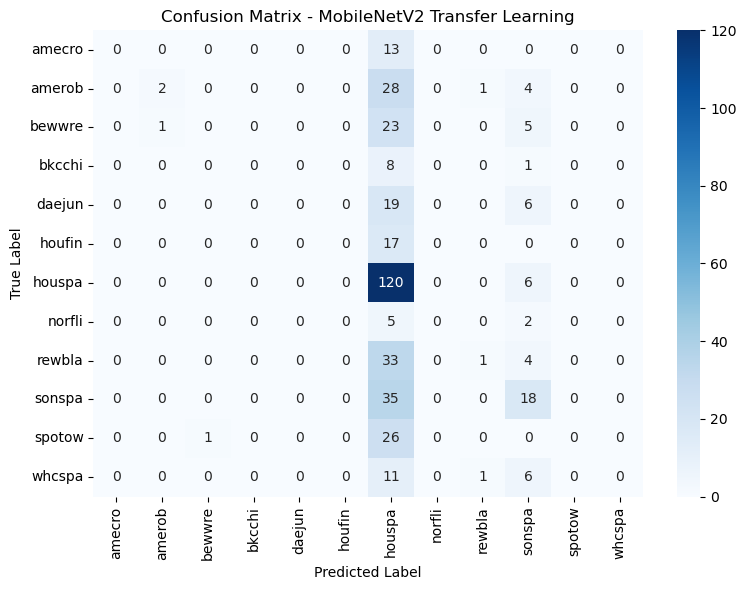

In [225]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def plot_model_performance_and_heatmap(history, model, X_val, y_val, class_names, model_name="Model"):
    """
    Plots training/validation accuracy & loss, and confusion matrix heatmap for a trained model.
    """
    # Predict on validation set
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Accuracy & Loss Curves
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.suptitle(f"Performance of {model_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Call the function like this:
plot_model_performance_and_heatmap(
    history=history_mobilenet,             
    model=mobilenet_model,                
    X_val=X_val_tf,                       
    y_val=y_val_mc,                        
    class_names=species_names,            
    model_name="MobileNetV2 Transfer Learning"
)

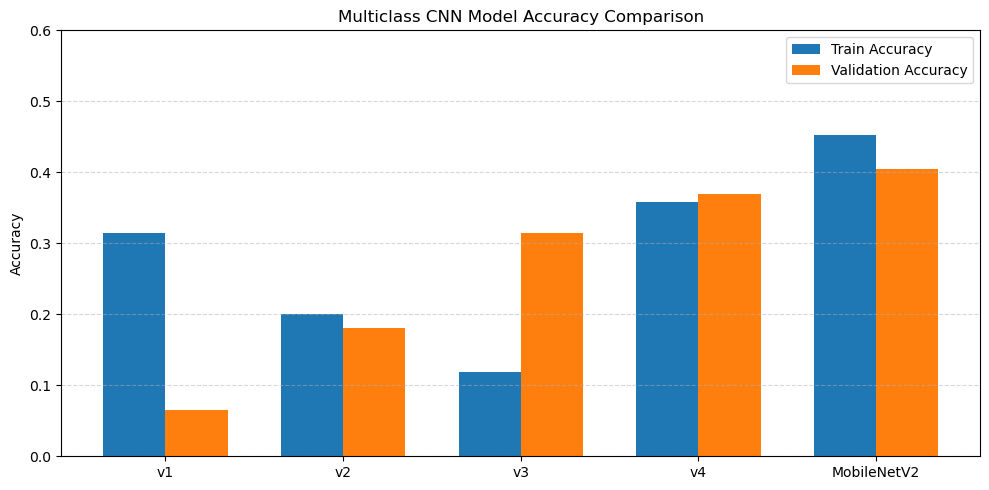

In [229]:
import matplotlib.pyplot as plt
import numpy as np

# Model labels
models = ['v1', 'v2', 'v3', 'v4', 'MobileNetV2']

# Final accuracy values based on logs (corrected)
train_acc = [0.3139,0.2008, 0.1189, 0.358, 0.452]
val_acc   = [0.0655,0.1814, 0.3149, 0.370, 0.405]

# Plotting
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, train_acc, width, label='Train Accuracy')
plt.bar(x + width/2, val_acc, width, label='Validation Accuracy')
plt.ylim(0, 0.6)

plt.ylabel('Accuracy')
plt.title('Multiclass CNN Model Accuracy Comparison')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

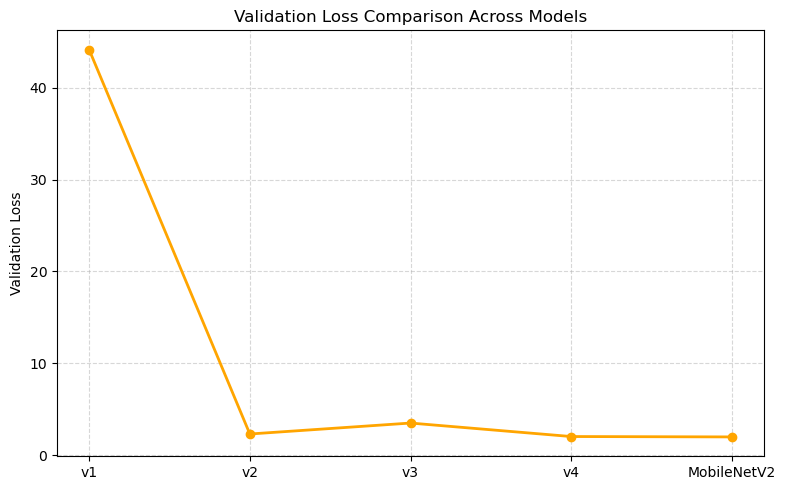

In [231]:
import matplotlib.pyplot as plt

models = ['v1', 'v2', 'v3', 'v4', 'MobileNetV2']
val_loss = [44.1239, 2.3118, 3.5041, 2.0362, 1.9947]  # Corrected losses

plt.figure(figsize=(8, 5))
plt.plot(models, val_loss, marker='o', color='orange', linewidth=2)
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison Across Models')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.image import resize

# Fix input shape for MobileNetV2 (resize + repeat to 3 channels)
def preprocess_for_mobilenet(X):
    X_rgb = np.repeat(X, 3, axis=-1)  # (N, 128, 517, 3)
    X_resized = tf.image.resize(X_rgb, (224, 224)).numpy()  # (N, 224, 224, 3)
    return X_resized

fig, axes = plt.subplots(3, 2, figsize=(16, 20))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    if name == "MobileNetV2":
        X_input = preprocess_for_mobilenet(X_val)
    else:
        X_input = X_val

    preds = model.predict(X_input)
    y_pred = np.argmax(preds, axis=1)
    cm = confusion_matrix(y_val, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=species_names,
                yticklabels=species_names,
                ax=axes[i])
    axes[i].set_title(f"Confusion Matrix - {name}")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

if len(models) < len(axes):
    for j in range(len(models), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()